In [2]:
# importing modules

import numpy as np
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import (InputLayer, Conv2D, MaxPooling2D, MaxPool2D, Flatten, 
                          Dense, BatchNormalization, Dropout, ELU, UpSampling2D,GlobalAveragePooling2D)
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Nadam
from keras.layers import Input, Multiply, UpSampling2D
from keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [3]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split

def is_image_dark(image, threshold=30):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mean_intensity = np.mean(gray_image)
    return mean_intensity < threshold

def image_to_hash(image):
    resized = cv2.resize(image, (8, 8))
    gray_image = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    return tuple(gray_image.flatten())

def is_grayscale(image):
    if len(image.shape) == 2:  # Image is already grayscale
        return True
    elif len(image.shape) == 3 and image.shape[2] == 1:  # Single-channel image
        return True
    elif len(image.shape) == 3 and image.shape[2] == 3:  # Check if R, G, B channels are equal
        return np.all(image[:,:,0] == image[:,:,1]) and np.all(image[:,:,1] == image[:,:,2])
    return False

def apply_color_jitter(image):
    # Randomly adjust brightness, contrast, saturation, and hue
    brightness = np.random.uniform(0.8, 1.2)
    contrast = np.random.uniform(0.8, 1.2)
    saturation = np.random.uniform(0.8, 1.2)

    # Convert image to float32 for calculations
    image = image.astype(np.float32) / 255.0

    # Adjust brightness
    image *= brightness

    # Adjust contrast
    image = (image - 0.5) * contrast + 0.5
    image = np.clip(image, 0, 1)

    # Adjust saturation
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = np.stack([gray_image] * 3, axis=-1)  # Convert grayscale to 3 channels
    image = image * saturation + gray_image * (1 - saturation)

    # Convert back to uint8
    image = (image * 255).astype(np.uint8)
    
    return image

data_dir = "/kaggle/input/mushroom-classification/archive/Mushrooms"

# Create a mapping between category names and integer labels
category_map = {category: idx for idx, category in enumerate(sorted(os.listdir(data_dir)))}

# Load the dataset
images_list = []
labels_list = []
max_images_per_category = 300
seen_hashes = set()

for label_dir in os.listdir(data_dir):
    label_path = os.path.join(data_dir, label_dir)
    if os.path.isdir(label_path):
        label = category_map[label_dir]  # Get the integer label from the mapping
        category_images = 0
        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)
            try:
                image = cv2.imread(image_path)
                if image is not None:
                    # Check if the image is grayscale
                    if is_grayscale(image):
                        continue

                    # Check if the image is dark
                    if is_image_dark(image):
                        continue

                    # Check for duplicates
                    image_hash = image_to_hash(image)
                    if image_hash in seen_hashes:
                        continue
                    seen_hashes.add(image_hash)

                    # Apply color jitter
                    jittered_image = apply_color_jitter(image)

                    # Resize the image to 400x400
                    resized_image = cv2.resize(jittered_image, (224, 224))

                    images_list.append(resized_image)
                    labels_list.append(label)
                    category_images += 1

                    # Stop loading images for this category once we reach the limit
                    if category_images >= max_images_per_category:
                        break
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
                continue

# Convert to numpy arrays
images_array = np.array(images_list)
labels_array = np.array(labels_list)

# Normalize the images
images_array = images_array / 255.0

# One-hot encode the labels
num_categories = len(category_map)
predictor_labels = np.eye(num_categories)[labels_array]

# Split the data
x_train, x_temp, y_train, y_temp = train_test_split(images_array, predictor_labels, test_size=0.3, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# Print shapes
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)
print("x_val:", x_val.shape)
print("y_val:", y_val.shape)


Premature end of JPEG file


x_train: (1890, 224, 224, 3)
y_train: (1890, 9)
x_test: (405, 224, 224, 3)
y_test: (405, 9)
x_val: (405, 224, 224, 3)
y_val: (405, 9)


### VGG16

In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load the VGG16 model and create the feature extractor
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer('block5_pool').output)

# Freeze the convolutional base layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Add custom dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(9, activation='softmax')(x)

# Create the final model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         9,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,249,225 (58.17 MB)

 Trainable params: 534,537 (2.04 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [5]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
 1/60 ━━━━━━━━━━━━━━━━━━━━ 31:18 32s/step - accuracy: 0.0938 - loss: 2.3342

I0000 00:00:1717052280.461686     172 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717052280.482085     172 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.1839 - loss: 2.1677

W0000 00:00:1717052293.996888     172 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.39259, saving model to model.keras


W0000 00:00:1717052315.477737     173 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


60/60 ━━━━━━━━━━━━━━━━━━━━ 67s 597ms/step - accuracy: 0.1848 - loss: 2.1658 - val_accuracy: 0.3926 - val_loss: 1.8297 - learning_rate: 0.0010
Epoch 2/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.4074 - loss: 1.7301
Epoch 2: val_accuracy improved from 0.39259 to 0.40494, saving model to model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 0.4074 - loss: 1.7290 - val_accuracy: 0.4049 - val_loss: 1.7054 - learning_rate: 0.0010
Epoch 3/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.4631 - loss: 1.5278
Epoch 3: val_accuracy did not improve from 0.40494
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.4630 - loss: 1.5280 - val_accuracy: 0.3802 - val_loss: 1.6842 - learning_rate: 0.0010
Epoch 4/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.4735 - loss: 1.5146
Epoch 4: val_accuracy improved from 0.40494 to 0.44938, saving model to model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 0.4744 - loss: 1.5129 - val_accuracy: 0.4494 -

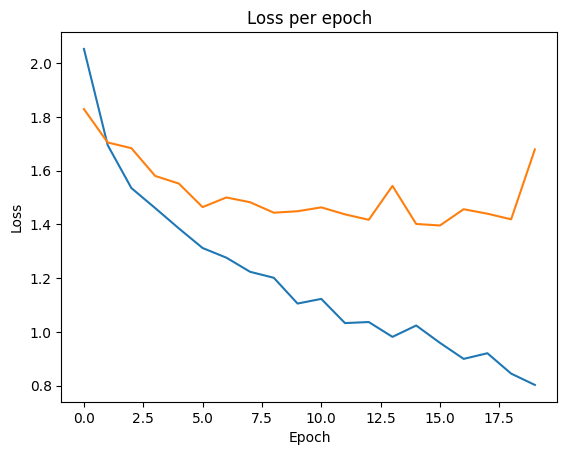

In [6]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

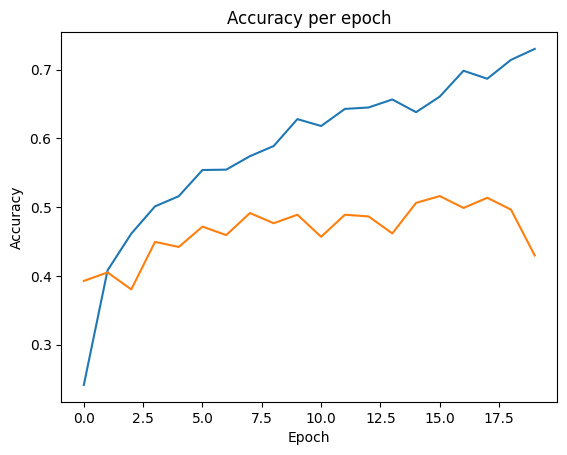

In [7]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### RESNET50

In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load the ResNet50 model and create the feature extractor
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=resnet50_model.input, outputs=resnet50_model.get_layer('conv5_block3_out').output)

# Freeze the convolutional base layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Add custom dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

output = Dense(9, activation='softmax')(x)

# Create the final model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('att_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

# Print the model summary
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,695,113 (98.02 MB)

 Trainable params: 2,107,401 (8.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
 2/60 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.1484 - loss: 2.7889  

W0000 00:00:1717052517.200592     172 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.1283 - loss: 2.4226

W0000 00:00:1717052526.692681     174 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717052531.672585     172 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.12593, saving model to att_model.keras


W0000 00:00:1717052539.083732     174 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 383ms/step - accuracy: 0.1283 - loss: 2.4212 - val_accuracy: 0.1259 - val_loss: 2.4249 - learning_rate: 0.0010
Epoch 2/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.1406 - loss: 2.3339
Epoch 2: val_accuracy did not improve from 0.12593
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.1410 - loss: 2.3312 - val_accuracy: 0.1136 - val_loss: 2.2973 - learning_rate: 0.0010
Epoch 3/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.1548 - loss: 2.2430
Epoch 3: val_accuracy improved from 0.12593 to 0.12840, saving model to att_model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.1546 - loss: 2.2421 - val_accuracy: 0.1284 - val_loss: 2.2427 - learning_rate: 0.0010
Epoch 4/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.1410 - loss: 2.2020
Epoch 4: val_accuracy improved from 0.12840 to 0.18272, saving model to att_model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.1416 - loss: 2.2009 - val_accuracy: 0.1

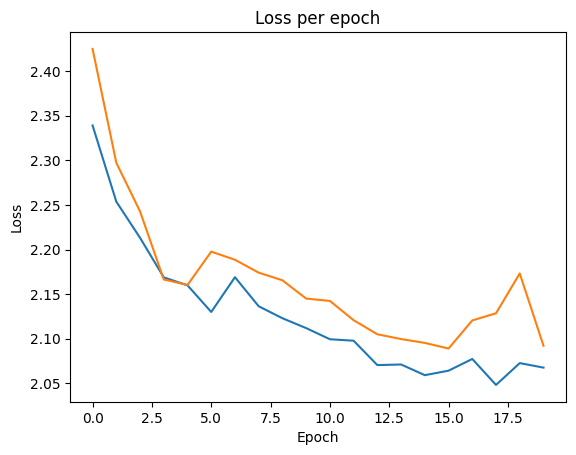

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

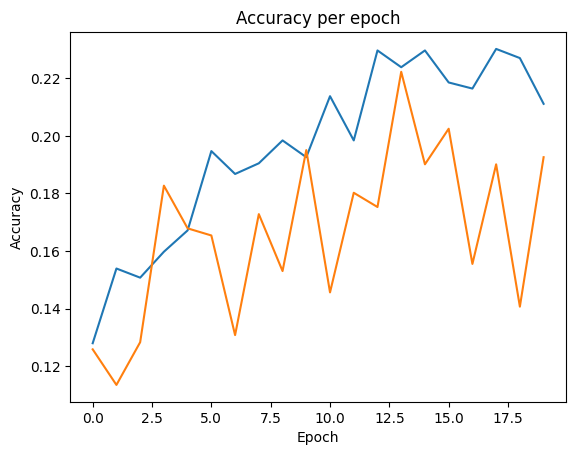

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### Xception

In [12]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load the Xception model and create the feature extractor
xception_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=xception_model.input, outputs=xception_model.get_layer('block14_sepconv2_act').output)

# Freeze the convolutional base layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Add custom dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

output = Dense(9, activation='softmax')(x)

# Create the final model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('att_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

# Print the model summary
model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer_2[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 22,968,881 (87.62 MB)

 Trainable params: 2,107,401 (8.04 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32, callbacks=[reduce_lr, model_checkpoint])

Epoch 1/20
 1/60 ━━━━━━━━━━━━━━━━━━━━ 20:10 21s/step - accuracy: 0.0938 - loss: 2.1877

W0000 00:00:1717052684.492466     172 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.3350 - loss: 2.0802

W0000 00:00:1717052696.037880     172 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717052699.976218     172 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.53086, saving model to att_model.keras


W0000 00:00:1717052711.990326     175 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


60/60 ━━━━━━━━━━━━━━━━━━━━ 49s 477ms/step - accuracy: 0.3366 - loss: 2.0740 - val_accuracy: 0.5309 - val_loss: 1.3008 - learning_rate: 0.0010
Epoch 2/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.6293 - loss: 1.0383
Epoch 2: val_accuracy did not improve from 0.53086
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.6293 - loss: 1.0390 - val_accuracy: 0.5309 - val_loss: 1.3161 - learning_rate: 0.0010
Epoch 3/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.6831 - loss: 0.9331
Epoch 3: val_accuracy improved from 0.53086 to 0.60988, saving model to att_model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.6835 - loss: 0.9317 - val_accuracy: 0.6099 - val_loss: 1.1793 - learning_rate: 0.0010
Epoch 4/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.7759 - loss: 0.6713
Epoch 4: val_accuracy did not improve from 0.60988
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.7758 - loss: 0.6716 - val_accuracy: 0.5778 - val_loss: 1.2776 - learning_

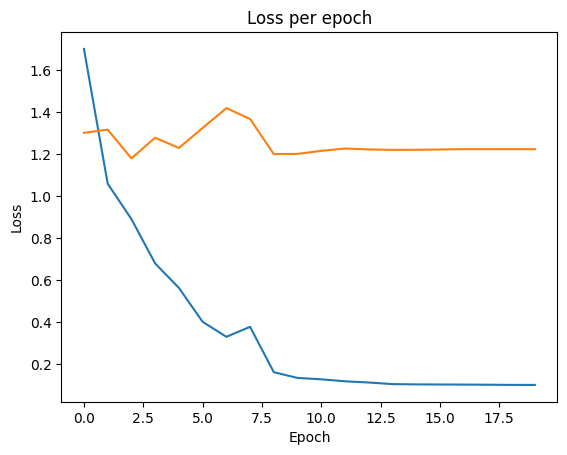

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

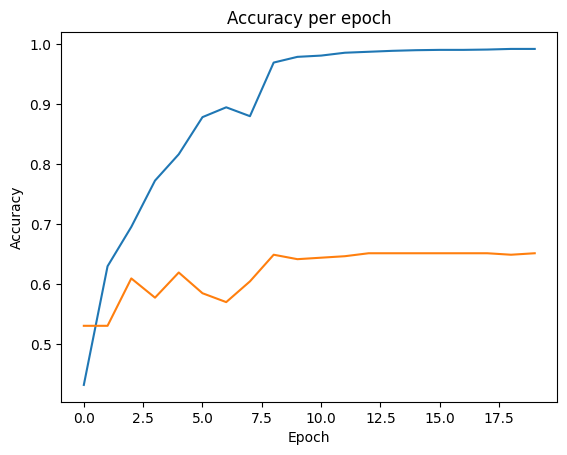

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### DenseNet121

In [16]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load the DenseNet121 model and create the feature extractor
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=densenet_model.input, outputs=densenet_model.get_layer('relu').output)

# Freeze the convolutional base layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Add custom dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

output = Dense(9, activation='softmax')(x)

# Create the final model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('att_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

# Print the model summary
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 8,096,329 (30.89 MB)

 Trainable params: 1,058,825 (4.04 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32, callbacks=[reduce_lr, model_checkpoint])

Epoch 1/20
 2/60 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.0391 - loss: 2.9115 

W0000 00:00:1717052922.837459     175 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.3162 - loss: 2.1134

W0000 00:00:1717052951.561902     175 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.59506, saving model to att_model.keras


W0000 00:00:1717052968.903661     172 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 797ms/step - accuracy: 0.3182 - loss: 2.1056 - val_accuracy: 0.5951 - val_loss: 1.1467 - learning_rate: 0.0010
Epoch 2/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6508 - loss: 0.9828
Epoch 2: val_accuracy did not improve from 0.59506
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.6510 - loss: 0.9832 - val_accuracy: 0.5901 - val_loss: 1.2013 - learning_rate: 0.0010
Epoch 3/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6589 - loss: 0.9642
Epoch 3: val_accuracy improved from 0.59506 to 0.60247, saving model to att_model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.6601 - loss: 0.9614 - val_accuracy: 0.6025 - val_loss: 1.0997 - learning_rate: 0.0010
Epoch 4/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7432 - loss: 0.7588
Epoch 4: val_accuracy improved from 0.60247 to 0.65679, saving model to att_model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.7435 - loss: 0.7575 - val_accuracy: 0.65

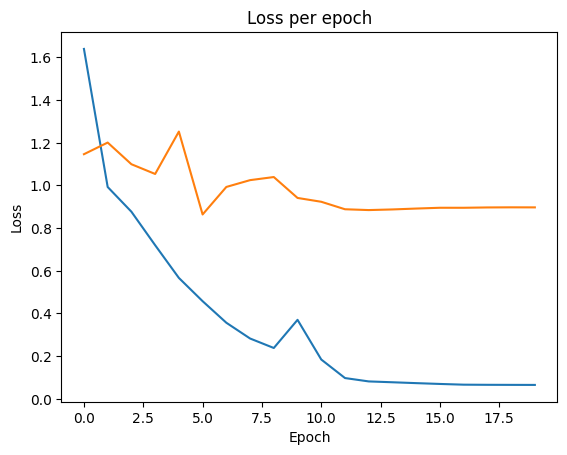

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

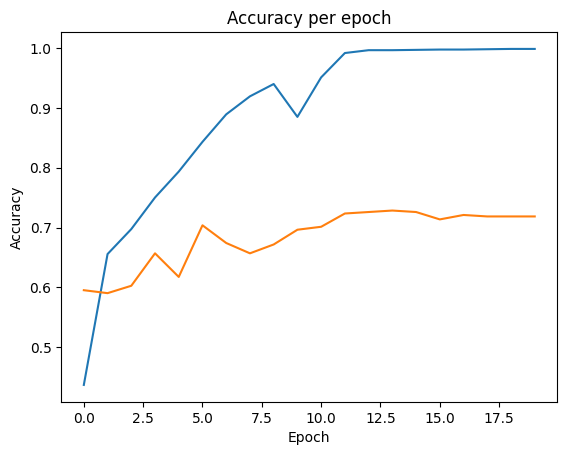

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### Inception-ResNet-V2

In [3]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load the InceptionResNetV2 model and create the feature extractor
inception_resnet_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=inception_resnet_model.input, outputs=inception_resnet_model.get_layer('conv_7b_ac').output)

# Freeze the convolutional base layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Add custom dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

output = Dense(9, activation='softmax')(x)

# Create the final model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('att_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

# Print the model summary
model.summary()

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 55,919,849 (213.32 MB)

 Trainable params: 1,583,113 (6.04 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [4]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32, callbacks=[reduce_lr, model_checkpoint])

Epoch 1/20


I0000 00:00:1717053864.729875     133 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717053864.854021     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.2591 - loss: 3.2970

W0000 00:00:1717053885.362442     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717053898.252432     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.46420, saving model to att_model.keras


W0000 00:00:1717053914.249701     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


60/60 ━━━━━━━━━━━━━━━━━━━━ 90s 868ms/step - accuracy: 0.2606 - loss: 3.2808 - val_accuracy: 0.4642 - val_loss: 1.5100 - learning_rate: 0.0010
Epoch 2/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.5063 - loss: 1.4219
Epoch 2: val_accuracy did not improve from 0.46420
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.5058 - loss: 1.4223 - val_accuracy: 0.3630 - val_loss: 1.7552 - learning_rate: 0.0010
Epoch 3/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5199 - loss: 1.3650
Epoch 3: val_accuracy improved from 0.46420 to 0.47654, saving model to att_model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 201ms/step - accuracy: 0.5207 - loss: 1.3631 - val_accuracy: 0.4765 - val_loss: 1.5392 - learning_rate: 0.0010
Epoch 4/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5645 - loss: 1.2527
Epoch 4: val_accuracy improved from 0.47654 to 0.54815, saving model to att_model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 202ms/step - accuracy: 0.5651 - loss: 1.2504 - val_accurac

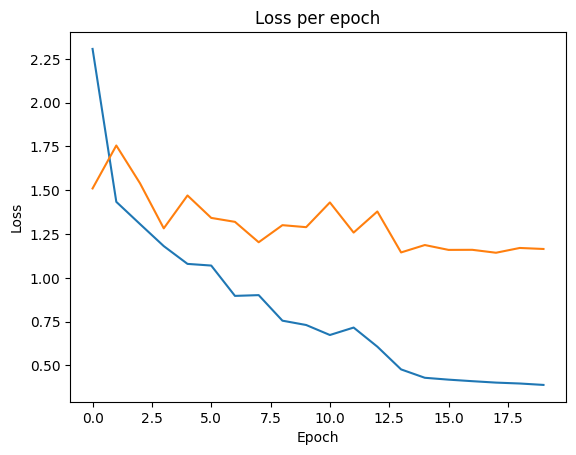

In [5]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

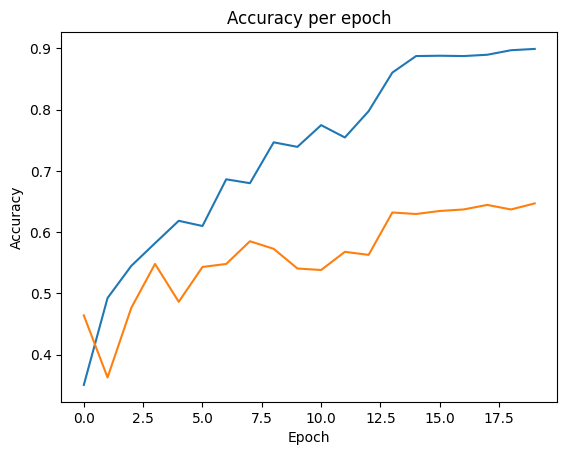

In [6]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### CNN

In [7]:
# importing modules

import numpy as np
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import (InputLayer, Conv2D, MaxPooling2D, MaxPool2D, Flatten, 
                          Dense, BatchNormalization, Dropout, ELU, UpSampling2D)
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Nadam
from keras.layers import Input, Multiply, UpSampling2D
from keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [4]:
#### from keras.regularizers import l2

model = Sequential() # sequential model

model.add(InputLayer(shape=(224,224, 3)))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding="same")) # convolution block with downsampling and batch normalization
model.add(MaxPool2D())

model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding="same")) # convolution block with downsampling and batch normalization
model.add(MaxPool2D())

model.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding="same")) # convolution block with downsampling and batch normalization
model.add(MaxPool2D())

model.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding="same")) # convolution block with downsampling and batch normalization

model.add(GlobalAveragePooling2D())

model.add(Dense(1024, activation='relu'))

model.add(Dense(9, activation='softmax'))

# callbacks: model checkpoint and reducing lr on plateau for focusing model towards problem
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

model.compile(optimizer=Nadam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy']) # compiling model layers

model.summary() # model summary

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         9,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 680,137 (2.59 MB)

 Trainable params: 680,137 (2.59 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:

history = model.fit(x_train,y_train,batch_size=32,epochs=70,verbose=1,validation_data=(x_val,y_val),callbacks=[reduce_lr,model_checkpoint])

Epoch 1/70
 2/60 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.1094 - loss: 2.1960  

I0000 00:00:1717063952.044614     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717063952.064704     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.1143 - loss: 2.1977

W0000 00:00:1717063960.599920     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.17037, saving model to model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 29s 207ms/step - accuracy: 0.1145 - loss: 2.1976 - val_accuracy: 0.1704 - val_loss: 2.1507 - learning_rate: 0.0010
Epoch 2/70
 1/60 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.1250 - loss: 2.1226

W0000 00:00:1717063964.277931     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.1586 - loss: 2.1296
Epoch 2: val_accuracy did not improve from 0.17037
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.1593 - loss: 2.1290 - val_accuracy: 0.1556 - val_loss: 2.1676 - learning_rate: 0.0010
Epoch 3/70
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.2051 - loss: 2.1137
Epoch 3: val_accuracy improved from 0.17037 to 0.23457, saving model to model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.2047 - loss: 2.1133 - val_accuracy: 0.2346 - val_loss: 2.0819 - learning_rate: 0.0010
Epoch 4/70
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.1983 - loss: 2.0949
Epoch 4: val_accuracy did not improve from 0.23457
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.1986 - loss: 2.0944 - val_accuracy: 0.1728 - val_loss: 2.3108 - learning_rate: 0.0010
Epoch 5/70
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.1943 - loss: 2.0820
Epoch 5: val_accuracy did not improve from 0.23457
60/60 ━━━━━━━━

In [6]:
# loading best model and testing

model1 = keras.models.load_model('model.keras', custom_objects={"ELU": keras.layers.ELU,"PReLU": keras.layers.PReLU}) # loading saved model

y_test_categorical = np.argmax(y_test, axis=1) # turning y_test probability distributions back to labels

y_pred_prob_val = model1.predict(x_test) # predicting

y_pred_val = np.argmax(y_pred_prob_val, axis=1) # turning y_pred probability distributions back to labels

# Accuracy
accuracy = accuracy_score(y_test_categorical, y_pred_val)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(y_test_categorical, y_pred_val, average='macro')
print("Precision:", precision)

# Recall
recall = recall_score(y_test_categorical, y_pred_val, average='macro')
print("Recall:", recall)

# F1 Score
f1 = f1_score(y_test_categorical, y_pred_val, average='macro')
print("F1 Score:", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_categorical, y_pred_val)
print("Confusion Matrix:")
print(conf_matrix)

11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

W0000 00:00:1717064258.372409     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Accuracy: 0.44938271604938274
Precision: 0.4390046463063926
Recall: 0.44866220267816814
F1 Score: 0.4401951073176563
Confusion Matrix:
[[23  6  0  3  4  0  3  1  1]
 [ 7 21  2  0  6  2  1  5  1]
 [ 0  5 31  3  2  1  2  1  3]
 [ 3  6  7  9  4  4  5  4  6]
 [ 9  5  2  4 25  1  2  3  0]
 [ 1  2  2  1  1 31  3  1  1]
 [ 2  1  4  4  2  2 11  5  6]
 [ 6  7  4  3  4  0  5 12  3]
 [ 1  0  5  4  4  2  9  4 19]]


W0000 00:00:1717064258.928301     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [7]:
model1.evaluate(x_test,y_test)

 7/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4660 - loss: 1.5457

W0000 00:00:1717064260.406923     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.4602 - loss: 1.6080


W0000 00:00:1717064260.986486     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[1.7206964492797852, 0.4493827223777771]

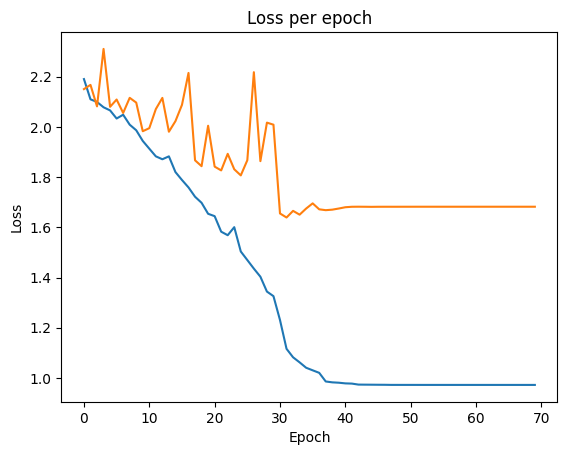

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

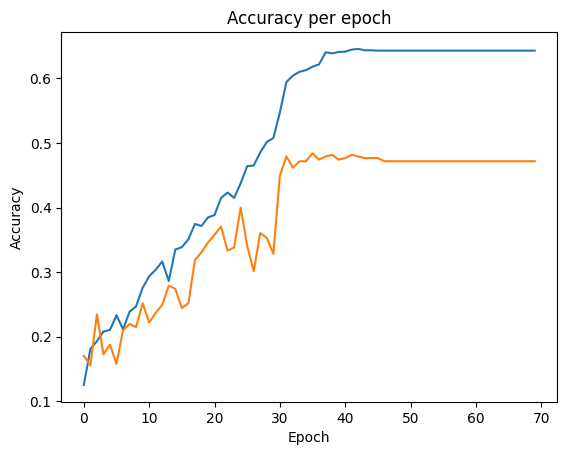

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### CNN with Attention

In [48]:
from keras.layers import Input, GlobalAveragePooling2D, Multiply, UpSampling2D
from keras.models import Model

def simple_attention(inputs):

    attention = Conv2D(1,1, activation='softmax')(inputs)
    
    attention = Multiply()([inputs, attention])
    
    return attention

# Input layer
inputs = Input(shape=(224, 224, 3), name='input_layer')

# Layer 1
layer1 = Conv2D(filters=64, kernel_size=3, activation='relu', padding="same")(inputs)
layer1 = BatchNormalization()(layer1)
layer1 = MaxPool2D()(layer1)

# Layer 2
layer2 = Conv2D(filters=64, kernel_size=3, activation='relu', padding="same")(layer1)
layer2 = BatchNormalization()(layer2)
layer2 = MaxPool2D()(layer2)

# Layer 3
layer3 = Conv2D(filters=128, kernel_size=3, activation='relu', padding="same")(layer2)
layer3 = BatchNormalization()(layer3)
layer3 = MaxPool2D()(layer3)

layer3 = Conv2D(filters=256, kernel_size=3, activation='relu', padding="same")(layer3)
layer3 = BatchNormalization()(layer3)
layer3 = MaxPool2D()(layer3)

attention_layer = simple_attention(layer3)

# Flatten and dense layers
x = GlobalAveragePooling2D()(attention_layer)

x = Dense(2048, activation='relu')(x)

outputs = Dense(9, activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

model_checkpoint = ModelCheckpoint('att_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

model.compile(optimizer=Nadam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_35[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_31    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 112, 112,  │     36,928 │ max_pooling2d_31… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_36[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_32    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 56, 56,    │     73,856 │ max_pooling2d_32… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_37[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_33    │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 28, 28,    │    295,168 │ max_pooling2d_33… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │      1,024 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_34    │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 14, 14, 1) │        257 │ max_pooling2d_34… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_11         │ (None, 14, 14,    │          0 │ max_pooling2d_34… │
│ (Multiply)          │ 256)              │            │ conv2d_39[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ multiply_11[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 2048)      │    526,336 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 954,826 (3.64 MB)

 Trainable params: 953,802 (3.64 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [49]:

history = model.fit(x_train,y_train,batch_size=32,epochs=70,verbose=1,validation_data=(x_val,y_val),callbacks=[reduce_lr,model_checkpoint])

Epoch 1/70
 2/60 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.0469 - loss: 2.5889

W0000 00:00:1717067123.297518     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.1762 - loss: 2.2926

W0000 00:00:1717067131.828020     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.11358, saving model to att_model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 157ms/step - accuracy: 0.1767 - loss: 2.2907 - val_accuracy: 0.1136 - val_loss: 2.4506 - learning_rate: 0.0010
Epoch 2/70
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.2559 - loss: 2.0143
Epoch 2: val_accuracy did not improve from 0.11358
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.2563 - loss: 2.0137 - val_accuracy: 0.0840 - val_loss: 2.4336 - learning_rate: 0.0010
Epoch 3/70
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.3161 - loss: 1.8916
Epoch 3: val_accuracy improved from 0.11358 to 0.11852, saving model to att_model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.3162 - loss: 1.8920 - val_accuracy: 0.1185 - val_loss: 2.9022 - learning_rate: 0.0010
Epoch 4/70
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.3446 - loss: 1.8059
Epoch 4: val_accuracy did not improve from 0.11852
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accur

In [50]:
# testing model 

model2 = keras.models.load_model('att_model.keras', custom_objects={"ELU": keras.layers.ELU,"PReLU": keras.layers.PReLU}) # loading saved model

y_test_categorical = np.argmax(y_test, axis=1) # turning y_test probability distributions back to labels

y_pred_prob_val = model2.predict(x_test) # predicting

y_pred_val = np.argmax(y_pred_prob_val, axis=1) # turning y_pred probability distributions back to labels

# Accuracy
accuracy = accuracy_score(y_test_categorical, y_pred_val)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(y_test_categorical, y_pred_val, average='macro')
print("Precision:", precision)

# Recall
recall = recall_score(y_test_categorical, y_pred_val, average='macro')
print("Recall:", recall)

# F1 Score
f1 = f1_score(y_test_categorical, y_pred_val, average='macro')
print("F1 Score:", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_categorical, y_pred_val)
print("Confusion Matrix:")
print(conf_matrix)

/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 14, 14, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

W0000 00:00:1717067501.510959     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Accuracy: 0.5555555555555556
Precision: 0.55832116454681
Recall: 0.5533446415948112
F1 Score: 0.5534266687184651
Confusion Matrix:
[[25  5  1  6  1  1  1  0  1]
 [ 4 31  2  1  2  2  0  1  2]
 [ 0  9 31  0  1  1  2  0  4]
 [ 4  3  3 23  3  0  4  2  6]
 [ 5  2  2  1 31  0  5  4  1]
 [ 0  1  0  2  1 28  5  1  5]
 [ 0  1  2  2  3  3 15  6  5]
 [ 5  1  1  2  4  2  7 20  2]
 [ 1  0  7  2  2  2  9  4 21]]


In [51]:
model2.evaluate(x_test,y_test)

/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 14, 14, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 5/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5566 - loss: 1.4147 

W0000 00:00:1717067503.768446     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.5648 - loss: 1.4163


[1.4879364967346191, 0.5555555820465088]

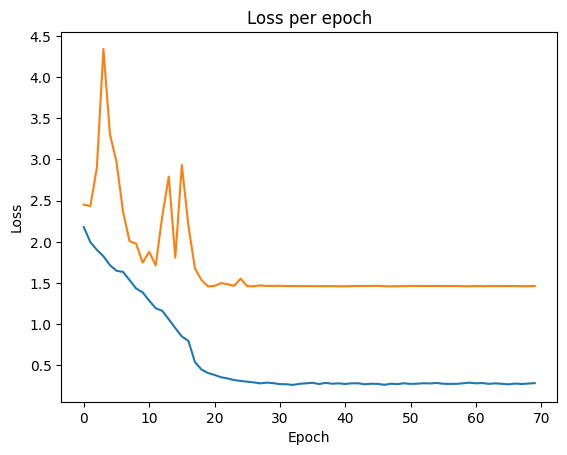

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

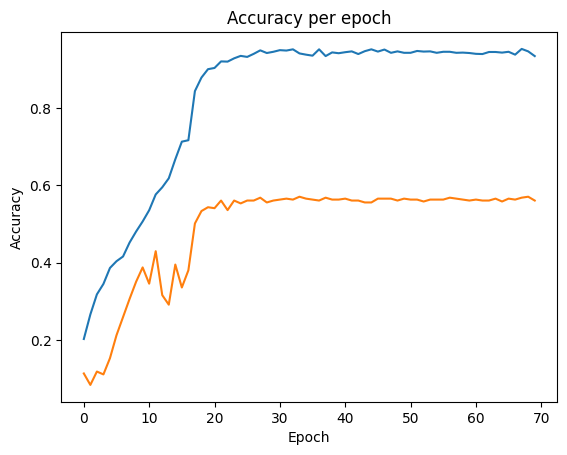

In [53]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()